# CBCT Calibration template notebook

## Load modules

In [159]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.color import hsv2rgb, rgb2hsv
from matplotlib.colors import ListedColormap
from tqdm.notebook import tqdm
from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse
import uncertainties as un

import sys
sys.path.append('../scripts/python')
import amglib.readers as io
import cbct.calibration as cbctcal

import importlib
importlib.reload(io)
importlib.reload(cbctcal)

calibration = {}

## Load data

In [2]:
datapath = '/Users/Shared/data/P20230561/02_rawdata/beads/'

dc  = io.read_images(datapath+'dc_{:05}.fits',first=1,last=3,averageStack=True,average='mean');
ob  = io.read_images(datapath+'ob_{:05}.fits',first=1,last=3,averageStack=True,average='mean');
cal = io.read_images(datapath+'proj_{:05}.fits',first=1,last=360,stride=2)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

### Show loaded data

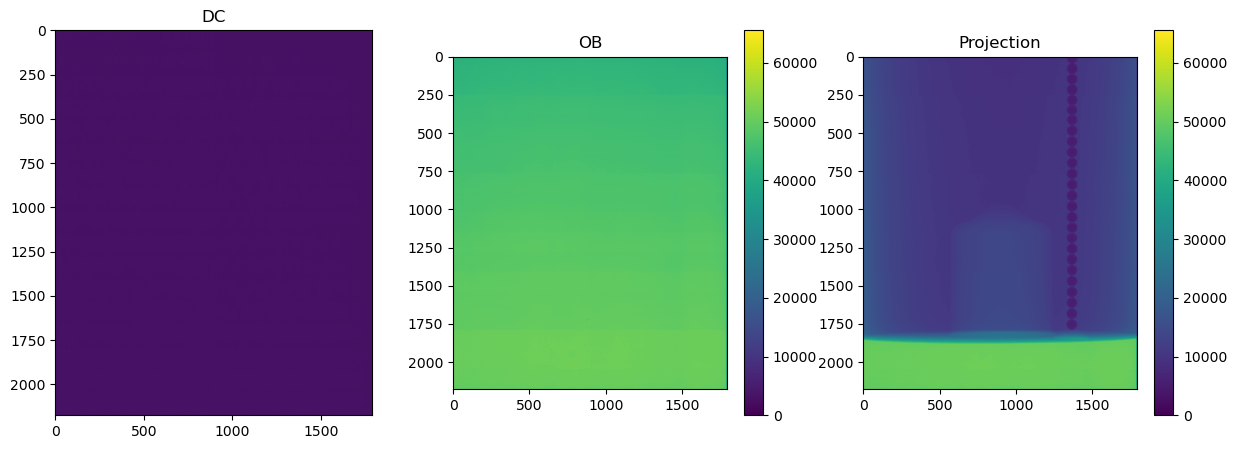

In [3]:
fig, ax = plt.subplots(1,3,figsize=(15,5))
ax=ax.ravel()
ax[0].imshow(dc)
ax[0].set_title('DC')
a1=ax[1].imshow(ob)
fig.colorbar(a1,ax=ax[1])
ax[1].set_title('OB')
a2=ax[2].imshow(cal[1,:,:])
fig.colorbar(a2,ax=ax[2])
ax[2].set_title('Projection');

## Preparing the projection data
### Normalize the projections

In [4]:
help(cbctcal.normalizeData)

Help on function normalizeData in module cbct.calibration:

normalizeData(img, ob, dc, flipProjection=False)
    Normalize the data using the given offset and dark current images.
    Arguments:
    - img: the image to normalize
    - ob: the offset image
    - dc: the dark current image
    - flipProjection: if True, the projection is flipped vertially after normalization
    
    Returns: A normalized image stack



In [5]:
lcal=cbctcal.normalizeData(cal,ob,dc, flipProjection=True)


#### Show normalized projection data

(180, 2176, 1792)


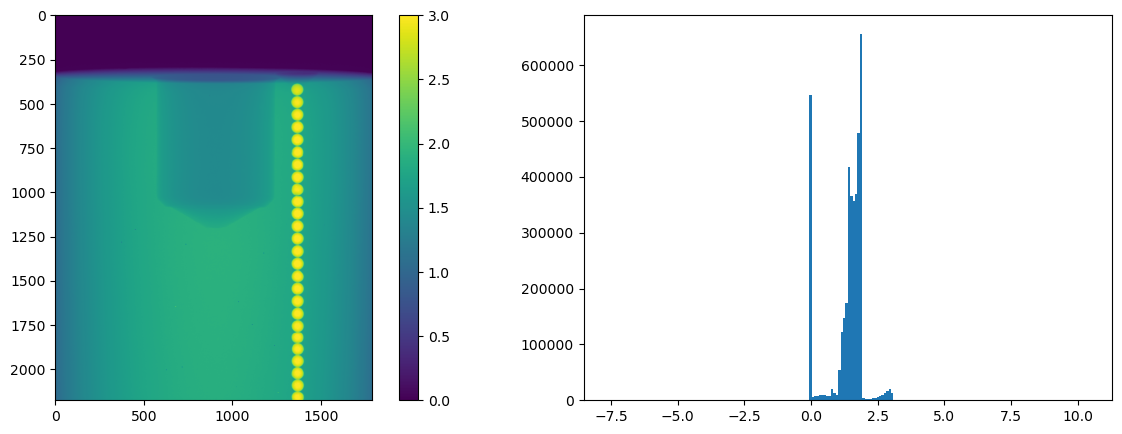

In [6]:
fig,ax=plt.subplots(1,2,figsize=(15,5))
im1 = ax[0].imshow(lcal[1],vmin=0,vmax=3)
fig.colorbar(im1, ax=ax[0], shrink=1)
ax[1].hist(lcal[1].ravel(),bins=200);
print(lcal.shape)

### Remove baseline from projection data

In [76]:
lcal=cbctcal.removeBaseline(lcal,usemin=False)

(2176, 1750) (180, 2176, 1750)


#### Show baseline removed projection data

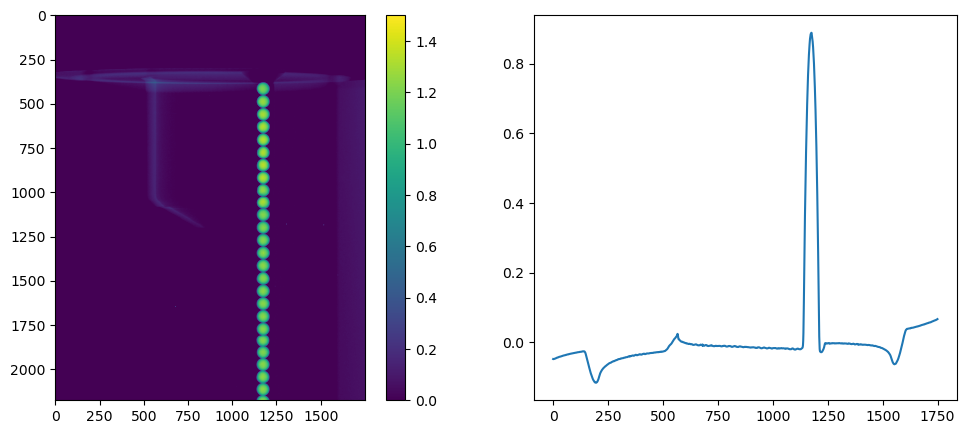

In [77]:
idx=10
plt.figure(figsize=[12,5])
plt.subplot(1,2,1)
plt.imshow(lcal[idx,:,:],vmin=0,vmax=1.5)
plt.colorbar()
plt.subplot(1,2,2)
plt.plot(lcal[idx,:,:].mean(axis=0)[:1750])

### Thresholding the beads
Test thresholding the projection data with removed baseline.

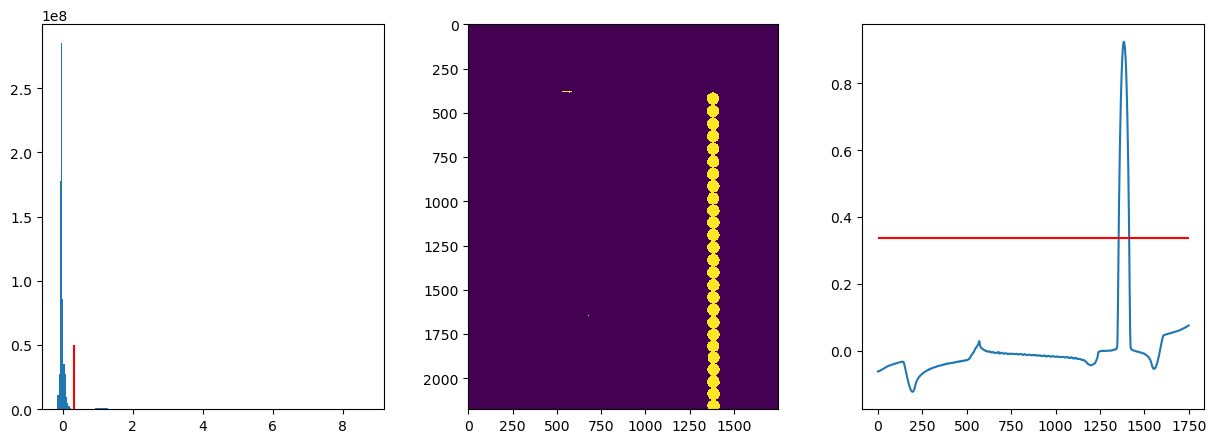

In [78]:
idx=0
m = lcal.mean()
s = lcal.std()
k=2
fig,ax=plt.subplots(1,3,figsize=[15,5])
ax[0].hist(lcal.ravel(),bins=256)
ax[0].vlines(m+k*s,ymin=0,ymax=5e7,color='r')
im=ax[1].imshow(m+k*s < lcal[idx,:,:],interpolation='None')
ax[2].plot(lcal[idx,:,:].mean(axis=0));
ax[2].hlines(m+k*s,xmin=0, xmax=lcal.shape[2],color='r');

### Apply constant thresholding to all projections

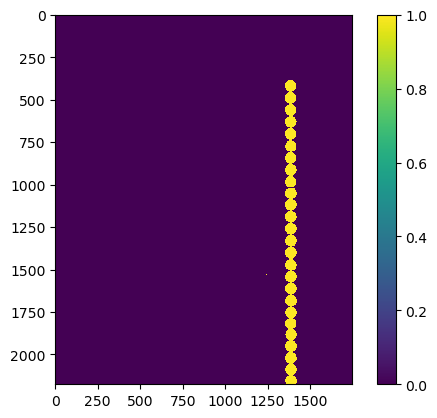

In [79]:
img = lcal
# Simple thresholding 
thresh_value =0.48

thresh_img = (thresh_value<img).astype(np.float32)


fig,ax=plt.subplots()
im1 = ax.imshow(thresh_img[0,:,:],vmin=0,vmax=1,interpolation='None')
fig.colorbar(im1, ax=ax, shrink=1)

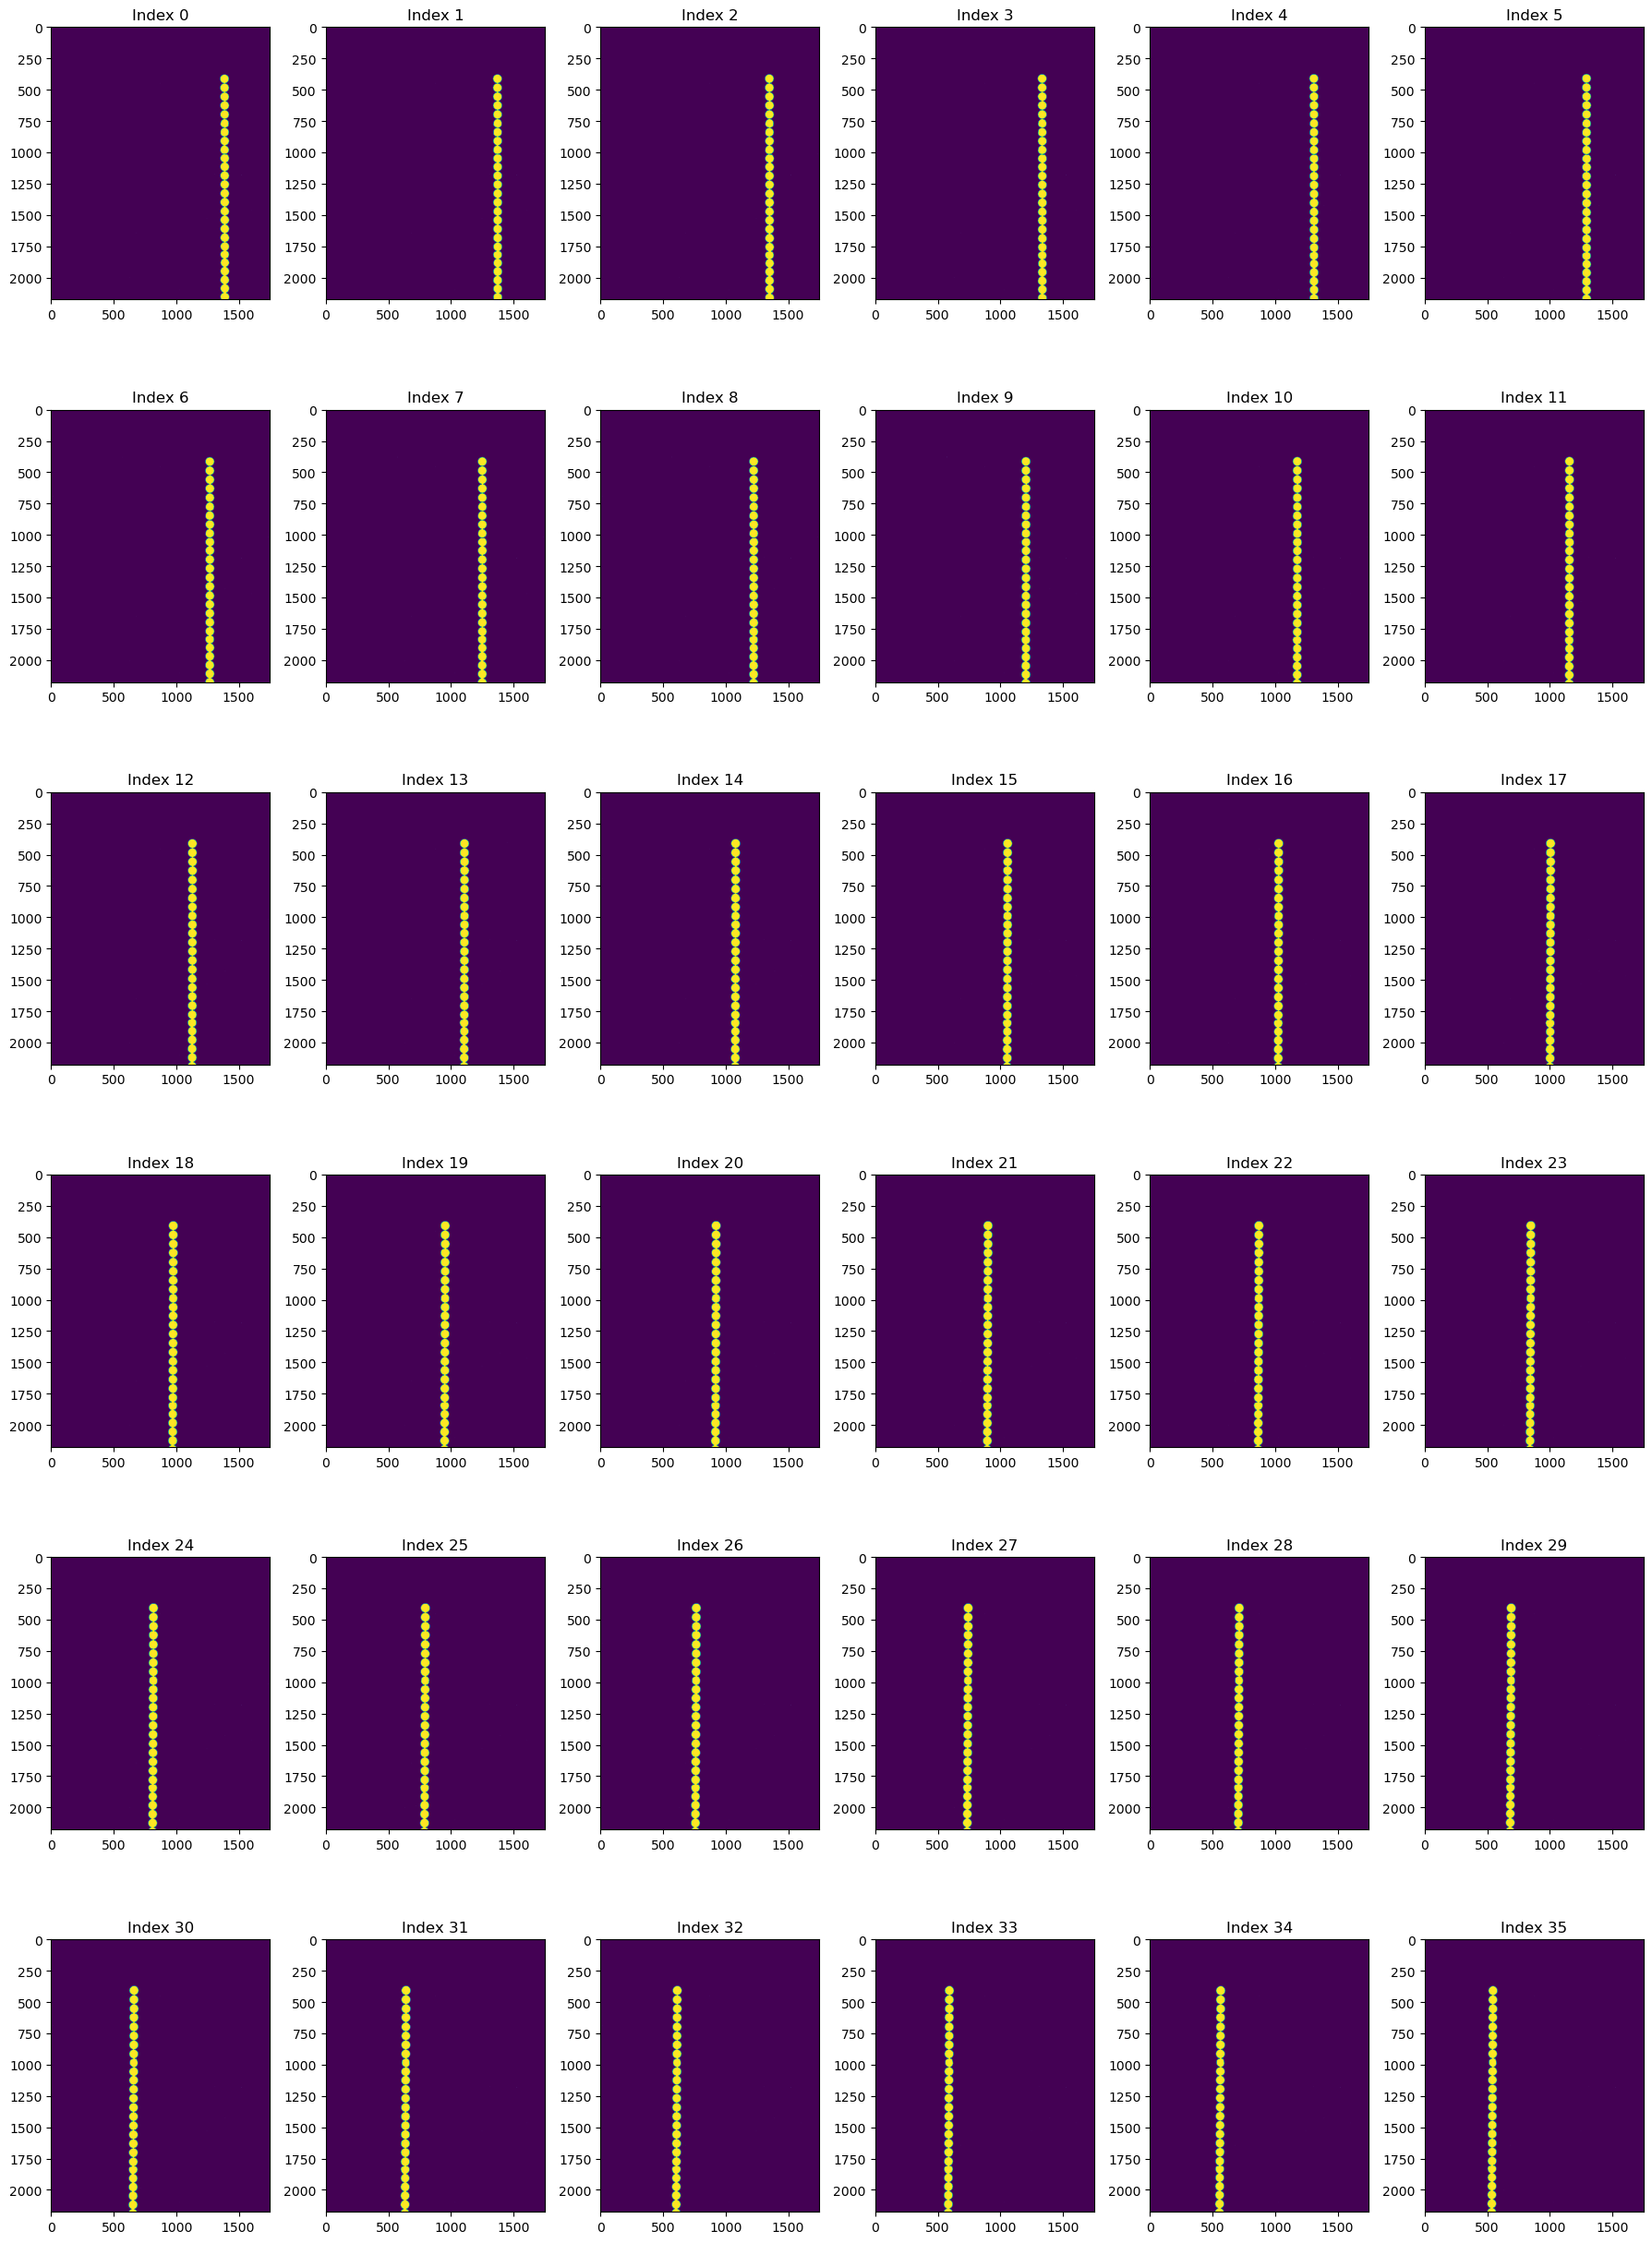

In [80]:
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(18, 25))

for i, ax in enumerate(axes.flat):
    im = ax.imshow(thresh_img[i, :, :], vmin=0, vmax=1)
    ax.set_title(f'Index {i}')  # Set a title for each subplot

plt.tight_layout()  # Adjust the spacing between subplots

### Clean the thresholded projections

In [81]:
eroded_img, dilated_img = cbctcal.erode_dilate(thresh_img, kernel_size=3, erosion_iterations=14, dilation_iterations=1)


#### Show the cleaned thresholded projections

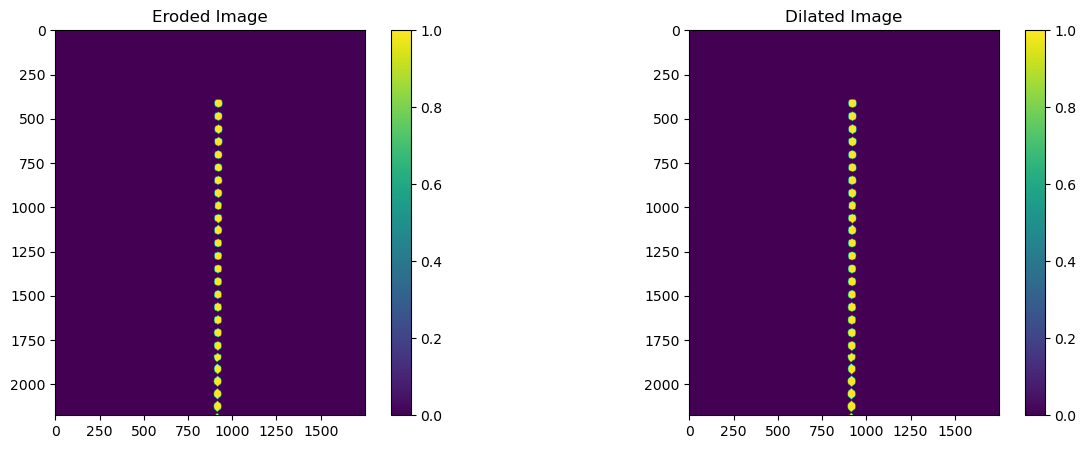

In [82]:
fig,ax=plt.subplots(1,2,figsize=(15,5))
im1 = ax[0].imshow(eroded_img[20,:,:],vmin=0,vmax=1)
fig.colorbar(im1, ax=ax[0], shrink=1)
ax[0].set_title('Eroded Image');
im2 = ax[1].imshow(dilated_img[20,:,:],vmin=0,vmax=1)
fig.colorbar(im2, ax=ax[1], shrink=1)
ax[1].set_title('Dilated Image');

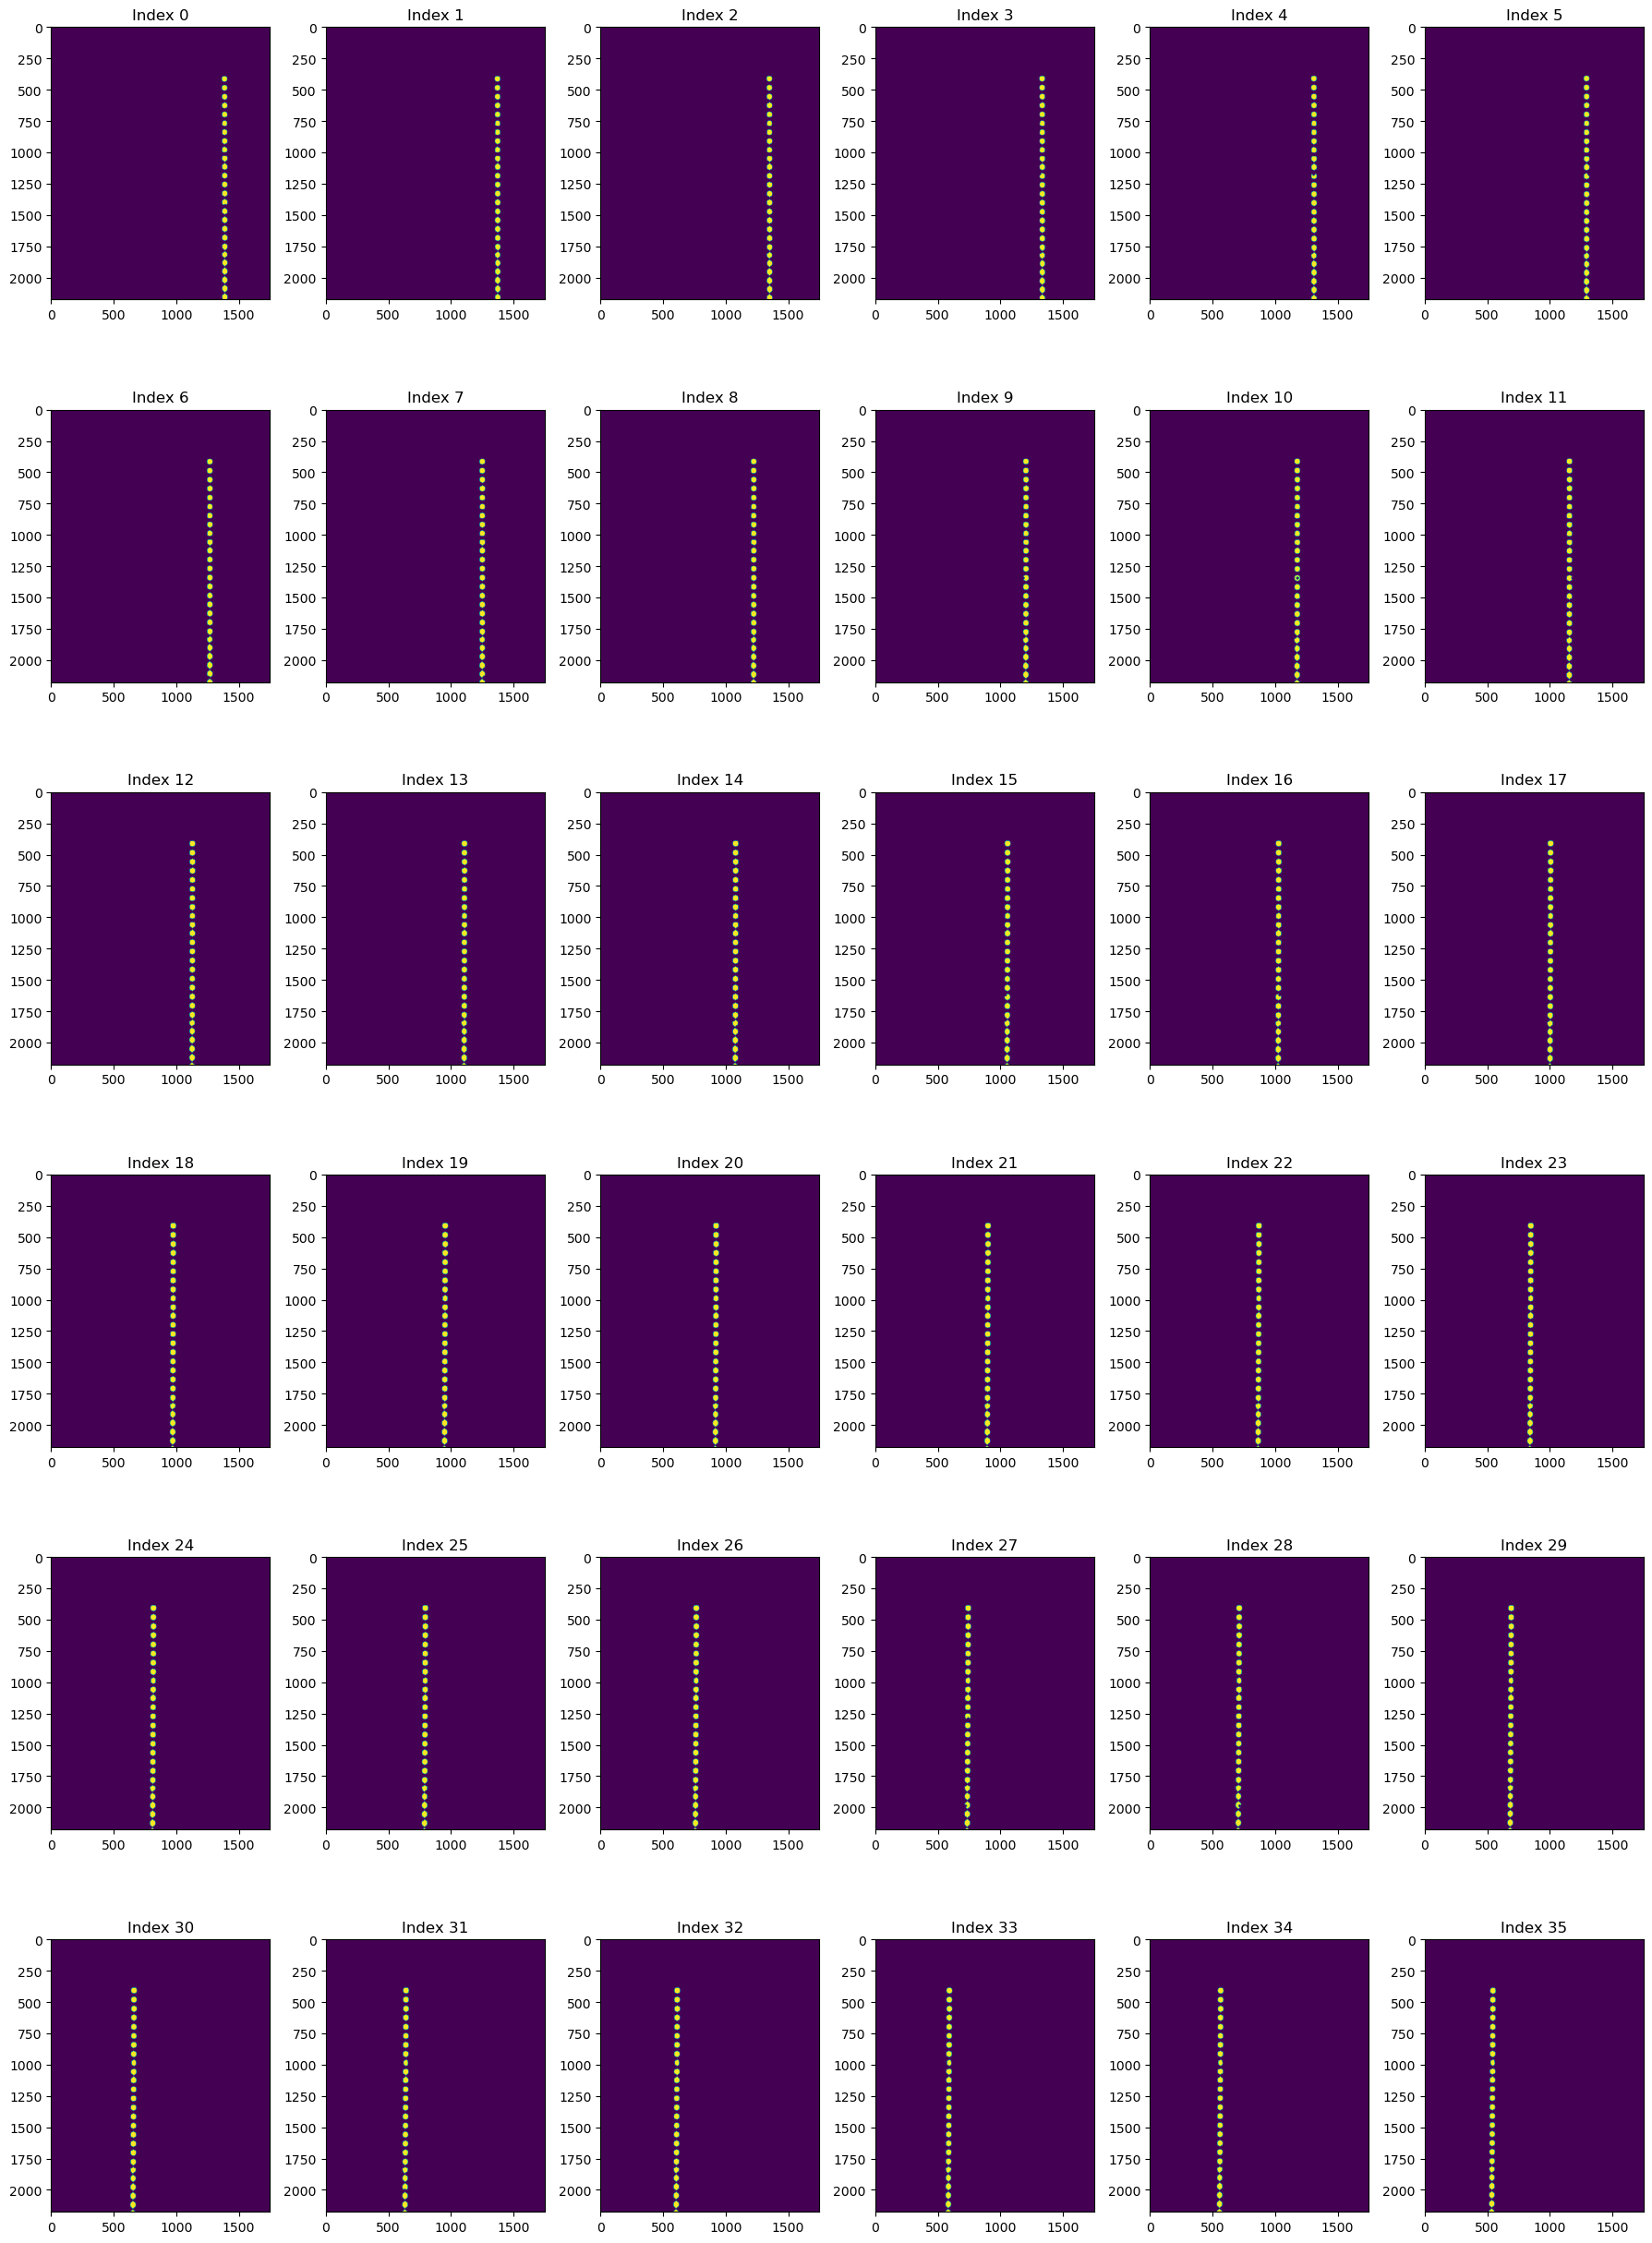

In [83]:
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(18, 25))

for i, ax in enumerate(axes.flat):
    im = ax.imshow(dilated_img[i, :, :], vmin=0, vmax=1)
    ax.set_title(f'Index {i}')  # Set a title for each subplot

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()

In [222]:
# Sensitivity threshold for detecting beads
sensitivity = 0.7

bead_positions,bead_intersections, bead_ids = cbctcal.find_beads(dilated_img, sensitivity=sensitivity,silent=True)

In [87]:
unique_lengths = set(len(sublist) for sublist in bead_positions)

print(f"Unique lengths of sublists: {unique_lengths}")

Unique lengths of sublists: {26, 27, 28, 29, 30}


## Find bead trajectories

### Show the tracked bead trajectories

In [88]:
trajectories = cbctcal.get_trajectories2(dilated_img,bead_positions,bead_ids=bead_ids)

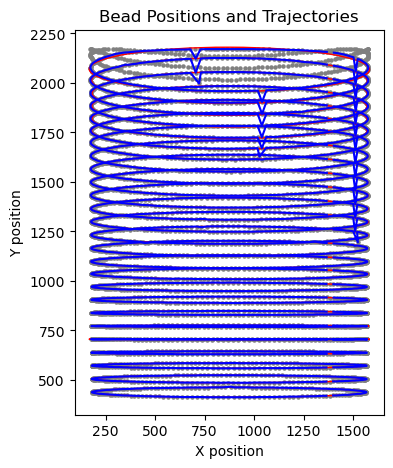

In [218]:
importlib.reload(cbctcal)

cbctcal.plot_trajectories(trajectories,bead_positions, showEllipses=True)

### Tune ellipse fitting

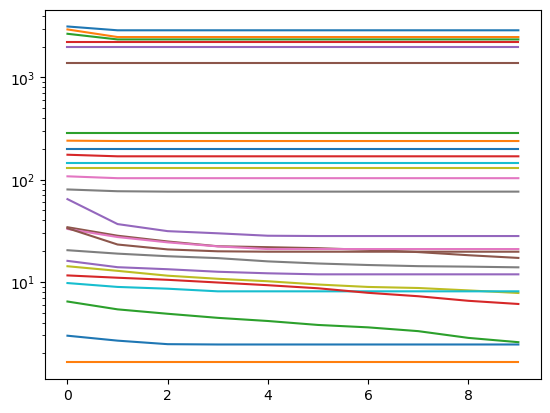

In [221]:
importlib.reload(cbctcal)

ellipses,sigma = cbctcal.fit_ellipses(trajectories,iterations=10,silent=True)
plt.semilogy(sigma.T);

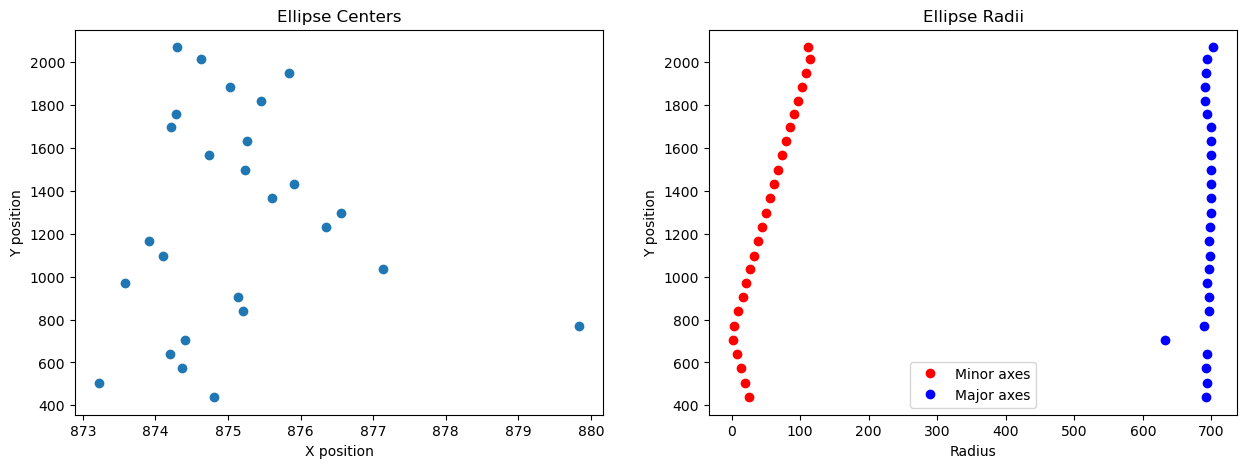

In [220]:
geom=cbctcal.ellipses_to_geometry(ellipses=ellipses)
cbctcal.plot_ellipse_parameters(geom)

## Calibrate the CBCT
### Find piercing point

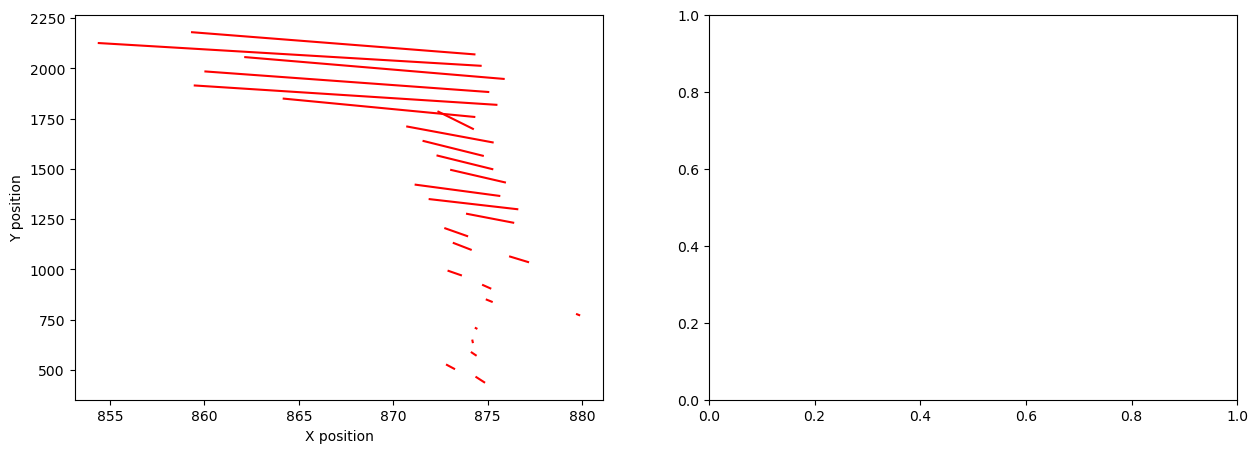

Intersection point: (2065.5541754949786,846.7321792172943)


In [160]:

importlib.reload(cbctcal)
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
ppx,ppy = cbctcal.fit_piercing_point(geom,silent=False)

calibration['piercing_point'] = {'x':ppx,'y':ppy}

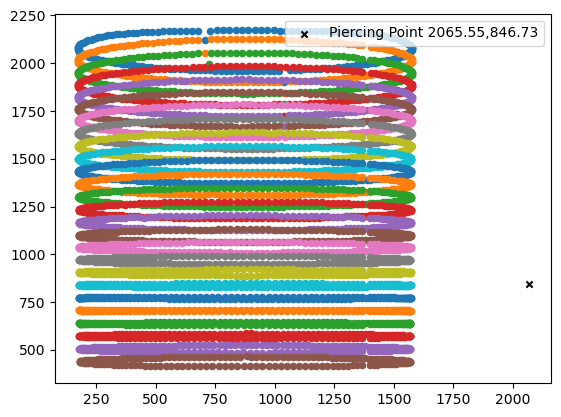

In [148]:
for ID in trajectories:
    if trajectories[ID][1] is not None:
         plt.scatter(trajectories[ID][0][:, 0], trajectories[ID][0][:, 1],s=20, marker='o')
plt.scatter(ppx,ppy, marker='x', s=20, color='k',label='Piercing Point {0:0.2f},{1:0.2f}'.format(ppx,ppy))
plt.legend()

### Find center of rotation

In [195]:
importlib.reload(cbctcal)
#fig,ax = plt.subplots(1,2,figsize=(15,5))
# center,tilt = cbctcal.center_of_rotation(ellipses,silent=False,oldversion=True,ax=ax[0])
center,tilt = cbctcal.center_of_rotation(ellipses,silent=True,oldversion=False)

calibration['center_of_rotation'] = {'x':center,'tilt':tilt}

(26, 1) (26, 1)


In [196]:
calibration

{'piercing_point': {'x': 2065.5541754949786, 'y': 846.7321792172943},
 'center_of_rotation': {'x': 875.0803745155545, 'tilt': 0.033554306665501625}}

### Find beamline distances

SOD median=  99.49851749892787
SDD median=  958.2851670935565
Magnification median=  9.67408169664295
Magnification ratio=  9.631150203859896
SOD stdev=  134.8456055924052
SDD stdev=  1186.1353329742913
SOD mean=  132.9635931157557
SDD mean=  1259.1890751569401


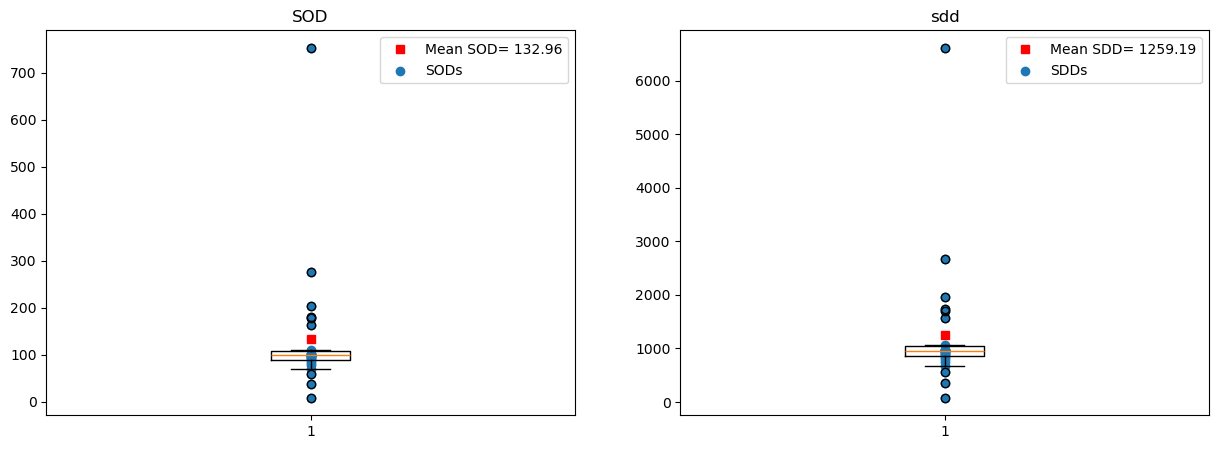

In [228]:
importlib.reload(cbctcal)
# vpiercing = 2176-ppy
vpiercing = ppy
hpiercing = 800

sod, sdd, mag_mean, mag_ratio = cbctcal.fit_beamline(ellipses,vpiercing,pixelSize=0.139, ringRadius=10.0,silent=False)

calibration['beamline'] = {'sod':sod,'sdd':sdd,'mag_mean':mag_mean,'mag_ratio':mag_ratio}


## Summarizing the calibration

In [225]:
import pandas as pd

df = pd.DataFrame(calibration).replace(np.nan, '')
df

,piercing_point,center_of_rotation,beamline
x,2065.554175,875.080375,
y,846.732179,,
tilt,,0.033554,
sod,,,132.963593
sdd,,,1259.189075
mag_mean,,,9.674082
mag_ratio,,,9.63115


In [226]:
lcal.shape

(180, 2176, 1750)